In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import seaborn as sns
sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import matplotlib as mpl

In [2]:
# load observation and simulation packages
from astrodatapy.number_density import number_density
from astrodatapy.correlation    import correlation
from astrodatapy.clustering     import clustering
# from illustris_python import *

In [3]:
myc = ['indianred','tan','darkseagreen','goldenrod',cmap(2),'tab:brown',\
       'skyblue','tab:olive','palevioletred']

colors = sns.color_palette("Set2")*4
color_maps     = ['Reds', 'Blues', 'Greens'] *4
markers        = ['o','s','v','^','<','>','p','*','D','.','8']*4
linestyles     = ['-','--','-.',':']*4


## GSMF

In [4]:
def mass_func(m,Lbox,lim_min,lim_max,nbin):
    bins = np.logspace(lim_min,lim_max,nbin)
    center = np.log10(bins)[:-1]+np.diff(np.log10(bins))/2
    count = np.histogram(m,bins)

    mask = count[0]>0
    fac = np.diff(np.log10(bins))*(Lbox/hh)**3
    yy = count[0]/fac
    err = yy[mask]/np.sqrt(count[0][mask])
    y1 = yy[mask]+err
    y2 = yy[mask]-err
    y2[y2<=0] = 1e-50
    return np.power(10,center[mask]),yy[mask], y1, y2

In [5]:
def plot_obs(ax,redshift,hh,feature,sim=False):
    obs    = number_density(feature=feature,z_target=redshift,quiet=1,h=hh)
    j_data = 0
    k_func = 0
    for ii in range(obs.n_target_observation):
        data       = obs.target_observation['Data'][ii]
        label      = obs.target_observation.index[ii]
        datatype   = obs.target_observation['DataType'][ii]
        color      = colors[ii]
        marker     = markers[j_data]
        linestyle  = linestyles[k_func]
        data[:,1:] = np.log10(data[:,1:])
        if datatype == 'data':
            ax.errorbar(data[:,0],  data[:,1], yerr = [data[:,1]-data[:,3],data[:,2]- data[:,1]],\
                        label=label,color='grey',fmt=marker,\
                        lw=1., capsize=5, capthick=2,alpha=0.4,markersize=7.)
            j_data +=1
        elif datatype == 'dataULimit':
            ax.errorbar(data[:,0],  data[:,1], yerr = -0.2*data[:,1], uplims=True,\
                        label=label,color=color,fmt=marker)
            j_data += 1
        elif sim:
            ax.plot(data[:,0],data[:,1],label=label,color='grey',linestyle=linestyle,lw=3)
            ax.fill_between(data[:,0], data[:,2],data[:,3],alpha=0.5,color='grey')
            k_func +=1

In [6]:
snap = 483
if snap > 294:
    pig = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_%d_subfind'%snap)
else:
    pig = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_%d_subfind'%snap)

# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [7]:
gLength = pig['FOFGroups/LengthByType']
gOffset = pig['FOFGroups/OffsetByType']
FirstSub = pig['FOFGroups/GroupFirstSub']

sLength = pig['SubGroups/SubhaloLenType2']
sOffset = pig['SubGroups/SubhaloOffsetType2']
sMass = pig['SubGroups/SubhaloMassType']

sBHMass = pig['SubGroups/SubhaloBHMass2']

NSubs = pig['FOFGroups/GroupNsubs']

### galaxy mass

In [8]:
mass4 = sMass[:][:,4] * 1e10/hh
lmin, lmax = 7, 13
x1,y1,y_lower,y_upper = mass_func(mass4,Lbox=Lbox/1000,lim_min=lmin,lim_max=lmax,nbin=30)

/tmp/ipykernel_84892/913865960.py:12: RuntimeWarning: divide by zero encountered in log10
  data[:,1:] = np.log10(data[:,1:])
/tmp/ipykernel_84892/913865960.py:12: RuntimeWarning: divide by zero encountered in log10
  data[:,1:] = np.log10(data[:,1:])


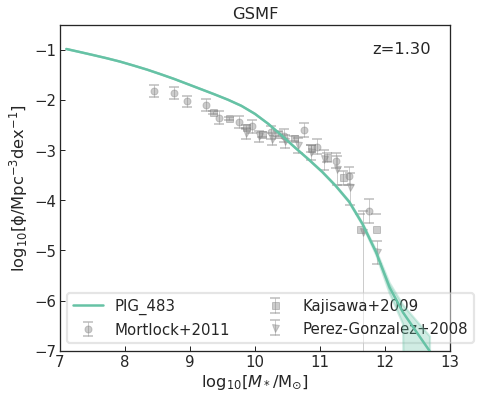

In [9]:
color=cmap(0)
label='PIG_%d'%snap
linestyle = '-'

feature = 'GSMF'
xlim    = (7, 13)
ylim    = (-7, -0.5)
xlabel  = r"$\log_{10}[M_*/{\rm M_{\odot}}]$"
ylabel  = r"$\log_{10}[\rm \phi/Mpc^{-3} dex^{-1}]$"



fig, ax = plt.subplots(1,1,figsize=(7,6))

plot_obs(ax,redshift,hh,feature)


ax.plot(np.log10(x1),np.log10(y1),color=color,label=label,zorder=1000,linestyle=linestyle)
ax.fill_between(np.log10(x1),np.log10(y_lower),\
                    np.log10(y_upper),color=cmap(0),alpha=0.3,zorder=1000)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.text(0.95,0.95, "z=%.2f"%redshift,horizontalalignment='right',\
      verticalalignment='top',transform=ax.transAxes)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)  
leg = ax.legend(ncol=2,loc='lower left')
leg.get_frame().set_alpha(0.5)
ax.set_title(feature)

plt.show()

### subhalo BH mass

In [10]:
# total mass
mass5 = pig['SubGroups/SubhaloBHMass2'][:] *1e10/hh

# central mass
len5 = pig['SubGroups/SubhaloLenType2'][:][:,5]

mask5 = mass5 > 1
mask5 &= len5 > 0
mask5 &= mass4 > 1

mdot_msun_yr = 1e10/980/1e6
mdot = pig['SubGroups/SubhaloBHMdot2'][:] * mdot_msun_yr

In [11]:
rhalf4 = pig['SubGroups/SubhaloHalfmassRadType'][:][:,4]
sfr = pig['SubGroups/SubhaloSFR'][:]

### galaxy scatter relations

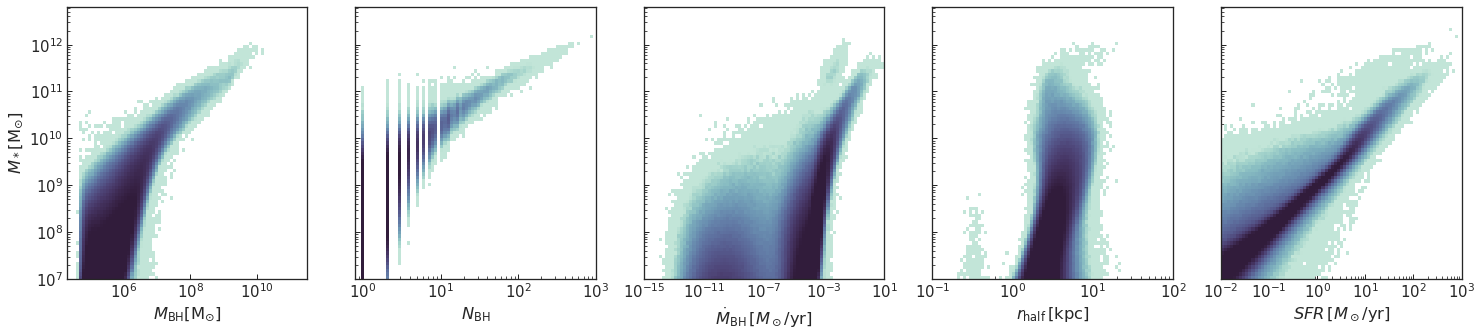

In [12]:
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)


ylabel  = r"$M_*[{\rm M_{\odot}}]$"


fig, ax = plt.subplots(1,5,figsize=(25,5), sharey=True)


ymin, ymax = 7., 12.8
ybins = np.logspace(ymin,ymax, 80)

#----------------------------------------------------
xlabel  = r"$M_{\rm BH}[{\rm M_{\odot}}]$"
xmin, xmax = 4.3, 11.5
xbins = np.logspace(xmin,xmax, 80)

ax[0].hist2d(mass5, mass4, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[0].set(xscale='log', yscale='log', xlabel=xlabel, ylabel=ylabel)

#----------------------------------------------------
xlabel = r'$N_{\rm BH}$'
xmin, xmax = -0.1, 3.
xbins = np.logspace(xmin,xmax, 80)

ax[1].hist2d(len5, mass4, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[1].set(xscale='log', yscale='log', xlabel=xlabel)


#----------------------------------------------------
xlabel = r'$\dot{M}_{\rm BH}\,[M_\odot/{\rm yr}]$'
xmin, xmax = -15, 1
xbins = np.logspace(xmin,xmax, 80)

ax[2].hist2d(mdot, mass4, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[2].set(xscale='log', yscale='log', xlabel=xlabel)

#----------------------------------------------------
xlabel = r'$r_{\rm half}\,[{\rm kpc}]$'
xmin, xmax = -1, 2
xbins = np.logspace(xmin,xmax, 80)

ax[3].hist2d(rhalf4, mass4, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[3].set(xscale='log', yscale='log', xlabel=xlabel)


#----------------------------------------------------
xlabel = r'$SFR\,[M_\odot/{\rm yr}]$'
xmin, xmax = -2, 3
xbins = np.logspace(xmin,xmax, 80)

ax[4].hist2d(sfr, mass4, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[4].set(xscale='log', yscale='log', xlabel=xlabel)


plt.show()

In [26]:
# test galaxy mass
tol = 0.1
idxs = np.random.randint(low=0, high=50000000, size=100, dtype=int)
for i in idxs:
    beg = pig['SubGroups/SubhaloOffsetType2'][i]
    end = beg + pig['SubGroups/SubhaloLenType2'][i]
    
    mbt = pig['SubGroups/SubhaloMassType'][i]
    bhmass = pig['SubGroups/SubhaloBHMass'][i]
    
    m4 = sum(pig['4/Mass'][beg[4] : end[4]])
    m5 = sum(pig['5/BlackholeMass'][beg[5] : end[5]])
    
    if m4 > 0:
        assert np.abs(m4 - mbt[4])/mbt[4] < tol, "subhalo %d, sum mass: %.1e, mbt mass: %.1e"%(i, m4, mbt[4])
#     if bhmass > 0:
#         assert np.abs(m5 - bhmass)/bhmass < tol, "subhalo %d, sum mass: %.1e, mbt mass: %.1e"%(i, m5, bhmass)
    

### M_gal-Mbh with subidx

In [13]:
sidx5 = pig['5-2/SubgroupIndex'][:]
bhmass = pig['5-2/BlackholeMass'][:] * 1e10/hh
mass4 = sMass[:][:,4] * 1e10/hh


mass5 = pig['SubGroups/SubhaloBHMass2'][:] * 1e10/hh
mdot_msun_yr = 1e10/980/1e6
mdot = pig['SubGroups/SubhaloBHMdot2'][:] * mdot_msun_yr
spos = pig['SubGroups/SubhaloPos'][:]
bpos = pig['5-2/Position'][:]
mgal = mass4[sidx5]
spos5 = spos[sidx5]

In [14]:
sum(sidx5 < 0)

12011970

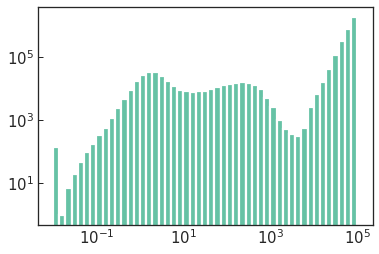

In [25]:
box = 250000
dpos = bpos - spos5
dpos[dpos > box/2] -= box
dpos[dpos < -box/2] += box
dr = np.linalg.norm(dpos, axis=1)

plt.hist(dr, bins = np.logspace(-2,6,50))
plt.xscale('log')
plt.yscale('log')
plt.show()

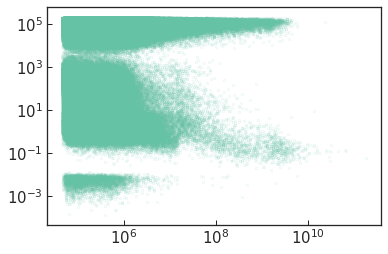

In [24]:


plt.scatter(bhmass, dr, s=0.01)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [15]:
mgal[:10]

array([1.12761364e+12, 1.12761364e+12, 1.12761364e+12, 1.12761364e+12,
       1.12761364e+12, 1.12761364e+12, 1.12761364e+12, 1.12761364e+12,
       1.12761364e+12, 1.12761364e+12])

In [23]:
mass4[:10]

array([1.12761364e+12, 5.38860182e+11, 3.13964048e+11, 1.52507842e+11,
       4.96454259e+11, 6.49165281e+11, 2.74104296e+11, 2.38580209e+11,
       5.51282321e+11, 3.33120835e+10])

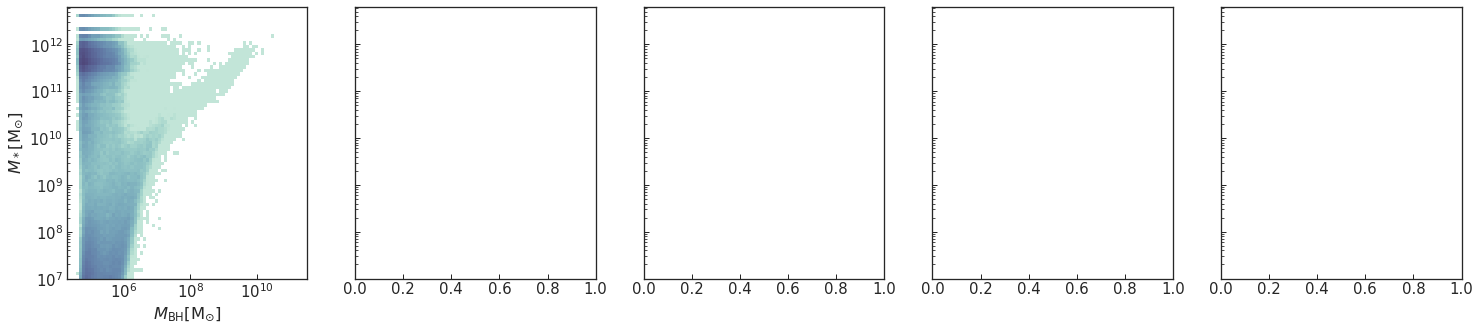

In [16]:
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)


ylabel  = r"$M_*[{\rm M_{\odot}}]$"


fig, ax = plt.subplots(1,5,figsize=(25,5), sharey=True)


ymin, ymax = 7., 12.8
ybins = np.logspace(ymin,ymax, 80)

#----------------------------------------------------
xlabel  = r"$M_{\rm BH}[{\rm M_{\odot}}]$"
xmin, xmax = 4.3, 11.5
xbins = np.logspace(xmin,xmax, 80)

ax[0].hist2d(bhmass, mgal, bins = [xbins, ybins], cmap=cc3,  cmin=2, norm=mpl.colors.LogNorm(vmin=20, vmax=9000))
ax[0].set(xscale='log', yscale='log', xlabel=xlabel, ylabel=ylabel)

plt.show()

### SFR

In [39]:
sfr = pig2['SubGroups/SubhaloVelDisp'][:20]

In [40]:
sfr

array([805.5747 , 478.30618, 362.4804 , 263.08997, 337.72855, 396.4282 ,
       305.5957 , 280.0392 , 381.44348, 156.45508, 286.3101 , 185.99117,
       277.86194, 223.29549, 184.37904, 155.7233 , 224.00772, 144.04353,
       156.07443, 173.40303], dtype=float32)

In [59]:
pig2['SubGroups/SubhaloRankInGr'][:20]

array([ 0,  1,  2,  6,  5,  3,  7, 10,  4, 20, 11, 16,  8, 12, 17, 27, 14,
       29, 25, 24], dtype=int32)